# Step 1: Write your Segmentation Algoirthm

Write a function that segments a leaf image, and returns a binary (`dtype='bool'`) image representing the segmentation.  Your algorithm must be based on thresholding and you should consider doing some region processing after segmentation to improve the result.

_Hint: You'll need to be a bit creative when devising your solution -- no single technique from class is likely to give you a particularly good solution, and you may need to think of some tricks that were not explicitly covered in class.  However, you can get a good result with a fairly simple algorithm.  You'll also need to decide how to handle the fact that the input images are colour, although this shouldn't pose too much of a problem, in fact, it is an advantage!_


In [18]:
import skimage.util as util
import skimage.io as io
import numpy as np
import os as os

# You can import other modules as needed.
import skimage.morphology as morph
import skimage.segmentation as seg
import gc as gc


def segLeaf(I):
    '''
    Segment a leaf image.
    :param I: Color leaf image to segment.
    :return: Logical image where True pixels represent foreground (i.e. leaf pixels).
    '''
    I_t = threshold_global(I, dist_metric=dist_green, second_pass=True)
    leaf_rough = max_component(morph.remove_small_objects(I_t)) 
    return morph.remove_small_holes(leaf_rough) 

def max_component(I, connectivity = 1):
    label = morph.label(I, connectivity=connectivity)
    label_freq = np.bincount(label.flatten())
    largest_label = np.argmax(label_freq[1:]) + 1   # excluding label 0
    return label == largest_label   

def threshold_global(I, dist_metric, second_pass = False):
    I_dist_map = dist_map(I, dist_metric=dist_green)
    T = iter_detect_t(I_dist_map)
    if second_pass:
        T = iter_detect_t(I_dist_map, part=I_dist_map < T)
    return I_dist_map < T

#def dist_color(p, c, order = None):
#    d = np.linalg.norm(p - c, ord=order)
#    return d

def dist_green(p, greenness = 0.1):
    return max(p[0] - p[1] * (1-greenness), 0) + max(p[2] - p[1] * (1-greenness), 0)

def dist_map(I, dist_metric):
    I_dist_map = np.zeros((np.size(I, 0), np.size(I, 1)))
    for r in range(0, np.size(I_dist_map, 0)):
        for c in range(0, np.size(I_dist_map, 1)):
            I_dist_map[r, c] = dist_metric(I[r, c])
    return I_dist_map

def iter_detect_t(I_float, part = None, eps = 0.1, init_guess = None):
    if part is None:
        part = np.ones_like(I_float, dtype=bool)
    I = I_float[part]
    if not init_guess:
        init_guess = np.mean(I)
    cur_T = init_guess
    prev_T = float('inf')
    while abs(cur_T - prev_T) > eps:
        less_than_T = I < cur_T
        forground = I[less_than_T]
        background = I[np.logical_not(less_than_T)]
        prev_T = cur_T
        cur_T = (np.mean(forground) + np.mean(background)) /2
    return cur_T

# Step 2: Implment Measures

Write functions to compute the Mean Squared Distance (MSD), Hausdorff Distance (HD) and Dice Similarity Coefficient (DSC) measures of segmentation quality.  

For MSD and HD, I suggest you reprsent boundaries by N-row, 2-column arrays where each row is the coordinate of one pixel on the region's boundary of the form [r,c], row first, then column.

In [21]:
def dice_similar_coef(I_seg, I_true):
    return 2 * np.sum(np.logical_and(I_seg, I_true)) / (np.sum(I_seg) + np.sum(I_true))

def mean_sq_dist(I_seg, I_true):
    I_seg_bp = boundary_points(I_seg)
    I_true_bp = boundary_points(I_true)
    sq_dist = 0
    m = np.size(I_seg_bp, 0)
    for i in range(0, m):
        sq_dist += bp_shortest_dist(I_seg_bp[i], I_true_bp) ** 2
    return sq_dist / m

def hausdorff_dist(I_seg, I_true):
    I_seg_bp = boundary_points(I_seg)
    I_true_bp = boundary_points(I_true)
    return max(bp_max_dist_A2B(I_seg_bp, I_true_bp), bp_max_dist_A2B(I_true_bp, I_seg_bp))

# helper functions
def bp_shortest_dist(x, points):
    x_mat = np.tile(x, (np.size(points, 0), 1))
    return np.min(np.linalg.norm(x_mat - points, axis=1))

def bp_max_dist_A2B(A, B):
    max_d = 0
    for i in range(0, np.size(A, 0)):
        d = bp_shortest_dist(A[i], B)
        if d > max_d:
            max_d = d
    return max_d

def boundary_points(B):
    bp = np.where(seg.find_boundaries(B > 0, connectivity=2, mode='inner') > 0)
    return np.transpose(np.vstack(bp)) 

# Step 3: Write a Validation driver program.

Write code that segments each image, and computes the MSD, HD, and DSC for each segmentation.  Print the MSD, HD, and DSC of each segmentation as you perform it.  At the end, print the average and standard deviation of the DSC, the MSD and the HD over all of the images.  Also print the percentage of regions that were "recognized" (see below).  Sample output is in the assignment description document.

The general approach should be, for each input image (in the `images` folder):

* load the image and it's ground truth
* segment the input image - this should be a binary image with a single region (connected component).
* extract the region boundary points from the segmented image and ground truth image; store them in Nx2 arrays as described above (see lecture nodes for an example on how to do this!).
* Compute the MSD and the HD from the two sets of boundary points (using the functions in Step 2).
* Compute the DSC from the segmented image and the ground truth image (using the function from Step 2).
* Determine whether the leaf was "recognized" (a leaf is recognized if it's DSC is greater than 0.6).
* Print the MSD, HD, and DSC to the console (see sample output).

When finished, don't forget to print the average and standard deviation of the DSC for all images, and the percentage of images where the leaf was "recognized".

_Feel free to define additional helper functions for your program if you think it will help._

In [20]:
#### Validate ####

# Paths for folders -- original and ground truth images
images_path = os.path.join('.', 'images')
gt_path = os.path.join('.', 'groundtruth')

stat_dsc = []
stat_msd = []
stat_hd = []

# Iterate over all files in the original images folder
for root, dirs, files in os.walk(images_path):
    for filename in files:
        # ignore files that are not PNG files.
        fname = os.path.join(root, filename)
        if filename[-4:] != '.png':
            continue
        
        img = util.img_as_float(io.imread(fname))
        gname = 'thresh' + os.path.basename(fname)
        img_true = util.img_as_float(io.imread(os.path.join(gt_path, gname)))

        img_seg = segLeaf(img)
        dsc = dice_similar_coef(img_seg, img_true)
        msd = mean_sq_dist(img_seg, img_true)
        hd = hausdorff_dist(img_seg, img_true)
        
        stat_dsc.append(dsc)
        stat_msd.append(msd)
        stat_hd.append(hd)

        print('DSC for ' + fname + ': %f' % dsc) 
        print('MSD for ' + fname + ': %f' % msd) 
        print('HD for ' + fname + ': %f' % hd) 
        print('--------------------------------------------------')
        
        gc.collect()

stat_dsc = np.array(stat_dsc)
stat_msd = np.array(stat_msd)
stat_hd = np.array(stat_hd)
        
print('The mean Dice coefficient was: %f' % np.mean(stat_dsc))
print('The std. deviation of Dice coefficient was: %f' % np.std(stat_dsc))
print('The mean MSD was: %f' % np.mean(stat_msd))
print('The std. deviation of MSD was: %f' % np.std(stat_msd))
print('The mean HD was: %f' % np.mean(stat_hd))
print('The std. deviation of HD was: %f' % np.std(stat_hd))
print('%d%% of leaves were recognized.' % round(sum(stat_dsc > 0.6) / 30 * 100))

DSC for ./images/image_0001.png: 0.990607
MSD for ./images/image_0001.png: 0.655590
HD for ./images/image_0001.png: 5.099020
--------------------------------------------------
DSC for ./images/image_0002.png: 0.984982
MSD for ./images/image_0002.png: 5.500997
HD for ./images/image_0002.png: 26.000000
--------------------------------------------------
DSC for ./images/image_0005.png: 0.980178
MSD for ./images/image_0005.png: 734.002209
HD for ./images/image_0005.png: 116.520384
--------------------------------------------------
DSC for ./images/image_0007.png: 0.988096
MSD for ./images/image_0007.png: 1.232282
HD for ./images/image_0007.png: 15.231546
--------------------------------------------------
DSC for ./images/image_0009.png: 0.989137
MSD for ./images/image_0009.png: 2.803950
HD for ./images/image_0009.png: 13.928388
--------------------------------------------------
DSC for ./images/image_0010.png: 0.987001
MSD for ./images/image_0010.png: 1.508402
HD for ./images/image_0010.pn

# Step 4:  Display Examples

Choose one input image where your algoirthm performed very well.  Choose another image where the algorithm did not perform well.  Display the two original images with the segmentation superimposed on top (There is an example in the lecture notes -- last slide, Topic 6 -- showing how to do this).  Also display the same two image's ground truth with the segmentation superimposed on top.    Title the images to indicate which is the "good" example, and which is the "bad" example.


Text(0.5,1,'Ground truth - image_0005.png')

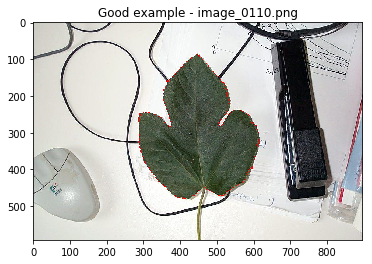

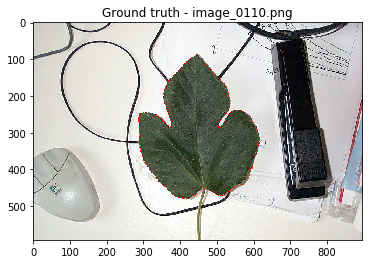

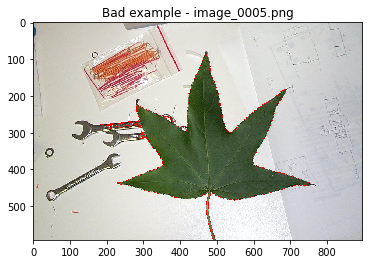

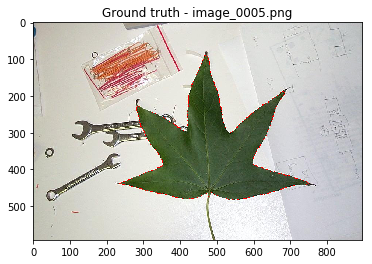

In [19]:
import matplotlib.pyplot as plt

% matplotlib inline
img1 = util.img_as_float(io.imread('./images/image_0110.png'))
gt1 = io.imread('./groundtruth/threshimage_0110.png')
ex1_seg = seg.mark_boundaries(img1, segLeaf(img1), color=(1, 0, 0))
ex1_gt = seg.mark_boundaries(img1, gt1, color=(1, 0, 0))

plt.figure()
plt.imshow(ex1_seg)
plt.title('Good example - image_0110.png')

plt.figure()
plt.imshow(ex1_gt)
plt.title('Ground truth - image_0110.png')

img2 = util.img_as_float(io.imread('./images/image_0005.png'))
gt2 = io.imread('./groundtruth/threshimage_0005.png')
ex2_seg = seg.mark_boundaries(img2, segLeaf(img2), color=(1, 0, 0))
ex2_gt = seg.mark_boundaries(img2, gt2, color=(1, 0, 0))

plt.figure()
plt.imshow(ex2_seg)
plt.title('Bad example - image_0005.png')

plt.figure()
plt.imshow(ex2_gt)
plt.title('Ground truth - image_0005.png')

# Step 5: A time for reflection.

### Answer the following questions right here in this block.

1. In a few sentences, briefly explain what your segmentation algorithm from Step 1 does and how it works.  

	_Your answer:_ 
Since the most significant feature of leaves is their color, we define a metric to measure how close is one RGB pixel to the color of leaves (Greenness). Then we can transform the color image to a “grayscale” image by applying this metric to each pixel. We implement an iterative threshold detection algorithm and threshold the transformed image twice, and finally we remove some small objects in the filtered image and apply component labelling, the largest connected component should be the leaf object.     

2. Consider your good result.  What, if anything, about your algoirthm is preventing you from getting a better result with this image?  If you weren't able to get any results, leave this blank, or explain what was preventing you from getting a result.

	_Your answer:_  

3. Consider your bad result.  What is it about your algoirthm caused the poor performance?   If you weren't able to get any results, leave this blank.

	_Your answer:_  
The overlapping object with similar color to the leaves may cause relatively poor performance.